In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "fsv3"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 297
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 369
Categorical Columns: 8


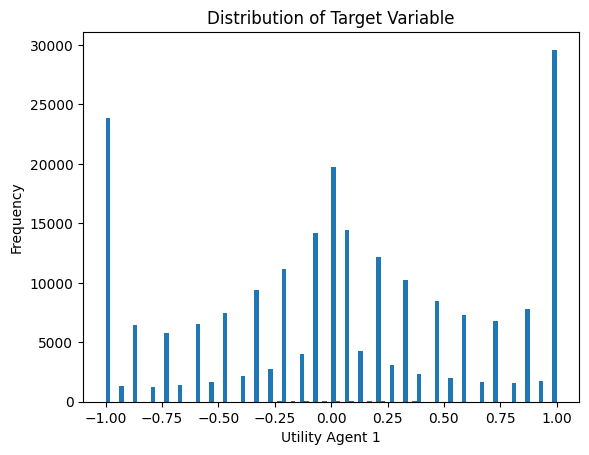

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55454


[100]	val-rmse:0.47129


[200]	val-rmse:0.45333


[300]	val-rmse:0.44702


[400]	val-rmse:0.44286


[500]	val-rmse:0.43969


[600]	val-rmse:0.43706


[700]	val-rmse:0.43546


[800]	val-rmse:0.43404


[900]	val-rmse:0.43280


[1000]	val-rmse:0.43206


[1100]	val-rmse:0.43136


[1200]	val-rmse:0.43073


[1300]	val-rmse:0.43022


[1400]	val-rmse:0.42989


[1500]	val-rmse:0.42969


[1600]	val-rmse:0.42938


[1700]	val-rmse:0.42919


[1800]	val-rmse:0.42890


[1900]	val-rmse:0.42876


[2000]	val-rmse:0.42855


[2100]	val-rmse:0.42839


[2200]	val-rmse:0.42836


[2300]	val-rmse:0.42831


[2400]	val-rmse:0.42810


[2499]	val-rmse:0.42801


Fold 1 - RMSE: 0.42769378232549393
Fold 2


[0]	val-rmse:0.59026


[100]	val-rmse:0.48725


[200]	val-rmse:0.46970


[300]	val-rmse:0.46365


[400]	val-rmse:0.45999


[500]	val-rmse:0.45725


[600]	val-rmse:0.45483


[700]	val-rmse:0.45329


[800]	val-rmse:0.45211


[900]	val-rmse:0.45108


[1000]	val-rmse:0.45022


[1100]	val-rmse:0.44943


[1200]	val-rmse:0.44874


[1300]	val-rmse:0.44833


[1400]	val-rmse:0.44785


[1500]	val-rmse:0.44745


[1600]	val-rmse:0.44710


[1700]	val-rmse:0.44685


[1800]	val-rmse:0.44660


[1900]	val-rmse:0.44623


[2000]	val-rmse:0.44599


[2100]	val-rmse:0.44573


[2200]	val-rmse:0.44569


[2300]	val-rmse:0.44547


[2400]	val-rmse:0.44531


[2499]	val-rmse:0.44517


Fold 2 - RMSE: 0.4449199168435837
Fold 3


[0]	val-rmse:0.60651


[100]	val-rmse:0.49055


[200]	val-rmse:0.47031


[300]	val-rmse:0.46299


[400]	val-rmse:0.45942


[500]	val-rmse:0.45623


[600]	val-rmse:0.45382


[700]	val-rmse:0.45188


[800]	val-rmse:0.45017


[900]	val-rmse:0.44938


[1000]	val-rmse:0.44863


[1100]	val-rmse:0.44794


[1200]	val-rmse:0.44736


[1300]	val-rmse:0.44677


[1400]	val-rmse:0.44649


[1500]	val-rmse:0.44621


[1600]	val-rmse:0.44582


[1700]	val-rmse:0.44564


[1800]	val-rmse:0.44550


[1900]	val-rmse:0.44541


[2000]	val-rmse:0.44522


[2100]	val-rmse:0.44511


[2200]	val-rmse:0.44491


[2300]	val-rmse:0.44479


[2400]	val-rmse:0.44464


[2499]	val-rmse:0.44460


Fold 3 - RMSE: 0.4440592811706702
Fold 4


[0]	val-rmse:0.59733


[100]	val-rmse:0.47901


[200]	val-rmse:0.45826


[300]	val-rmse:0.45088


[400]	val-rmse:0.44663


[500]	val-rmse:0.44271


[600]	val-rmse:0.44036


[700]	val-rmse:0.43868


[800]	val-rmse:0.43711


[900]	val-rmse:0.43578


[1000]	val-rmse:0.43496


[1100]	val-rmse:0.43401


[1200]	val-rmse:0.43361


[1300]	val-rmse:0.43293


[1400]	val-rmse:0.43243


[1500]	val-rmse:0.43210


[1600]	val-rmse:0.43164


[1700]	val-rmse:0.43139


[1800]	val-rmse:0.43108


[1900]	val-rmse:0.43084


[2000]	val-rmse:0.43066


[2100]	val-rmse:0.43027


[2200]	val-rmse:0.43019


[2300]	val-rmse:0.43019


[2400]	val-rmse:0.43018


[2499]	val-rmse:0.42995


Fold 4 - RMSE: 0.42963575852775376
Fold 5


[0]	val-rmse:0.54937


[100]	val-rmse:0.45149


[200]	val-rmse:0.43039


[300]	val-rmse:0.42292


[400]	val-rmse:0.41887


[500]	val-rmse:0.41504


[600]	val-rmse:0.41214


[700]	val-rmse:0.41017


[800]	val-rmse:0.40871


[900]	val-rmse:0.40755


[1000]	val-rmse:0.40656


[1100]	val-rmse:0.40584


[1200]	val-rmse:0.40512


[1300]	val-rmse:0.40459


[1400]	val-rmse:0.40417


[1500]	val-rmse:0.40379


[1600]	val-rmse:0.40340


[1700]	val-rmse:0.40319


[1800]	val-rmse:0.40311


[1900]	val-rmse:0.40298


[2000]	val-rmse:0.40292


[2100]	val-rmse:0.40275


[2200]	val-rmse:0.40276


[2300]	val-rmse:0.40272


[2400]	val-rmse:0.40257


[2499]	val-rmse:0.40249


Fold 5 - RMSE: 0.4021545535509219
List of oof scores: [0.42769378232549393, 0.4449199168435837, 0.4440592811706702, 0.42963575852775376, 0.4021545535509219]
Average oof score: 0.42969265848368465


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53667


[100]	val-rmse:0.45912


[200]	val-rmse:0.44184


[300]	val-rmse:0.43587


[400]	val-rmse:0.43257


[500]	val-rmse:0.42968


[600]	val-rmse:0.42725


[700]	val-rmse:0.42562


[800]	val-rmse:0.42440


[900]	val-rmse:0.42346


[1000]	val-rmse:0.42257


[1100]	val-rmse:0.42201


[1200]	val-rmse:0.42133


[1300]	val-rmse:0.42069


[1400]	val-rmse:0.42012


[1500]	val-rmse:0.41988


[1600]	val-rmse:0.41956


[1700]	val-rmse:0.41925


[1800]	val-rmse:0.41907


[1900]	val-rmse:0.41881


[2000]	val-rmse:0.41852


[2100]	val-rmse:0.41837


[2200]	val-rmse:0.41810


[2300]	val-rmse:0.41796


[2400]	val-rmse:0.41783


[2499]	val-rmse:0.41778


Fold 1 - RMSE: 0.4175189568727492
Fold 2


[0]	val-rmse:0.54880


[100]	val-rmse:0.43960


[200]	val-rmse:0.42079


[300]	val-rmse:0.41500


[400]	val-rmse:0.41199


[500]	val-rmse:0.41000


[600]	val-rmse:0.40878


[700]	val-rmse:0.40761


[800]	val-rmse:0.40675


[900]	val-rmse:0.40598


[1000]	val-rmse:0.40551


[1100]	val-rmse:0.40532


[1200]	val-rmse:0.40488


[1300]	val-rmse:0.40458


[1400]	val-rmse:0.40443


[1500]	val-rmse:0.40429


[1600]	val-rmse:0.40428


[1700]	val-rmse:0.40410


[1800]	val-rmse:0.40407


[1900]	val-rmse:0.40404


[2000]	val-rmse:0.40404


[2100]	val-rmse:0.40402


[2200]	val-rmse:0.40407


[2300]	val-rmse:0.40396


[2400]	val-rmse:0.40399


[2499]	val-rmse:0.40395


Fold 2 - RMSE: 0.40358242405059913
Fold 3


[0]	val-rmse:0.61452


[100]	val-rmse:0.49473


[200]	val-rmse:0.46980


[300]	val-rmse:0.46167


[400]	val-rmse:0.45759


[500]	val-rmse:0.45391


[600]	val-rmse:0.45084


[700]	val-rmse:0.44849


[800]	val-rmse:0.44693


[900]	val-rmse:0.44525


[1000]	val-rmse:0.44411


[1100]	val-rmse:0.44342


[1200]	val-rmse:0.44241


[1300]	val-rmse:0.44161


[1400]	val-rmse:0.44106


[1500]	val-rmse:0.44047


[1600]	val-rmse:0.44005


[1700]	val-rmse:0.43988


[1800]	val-rmse:0.43959


[1900]	val-rmse:0.43929


[2000]	val-rmse:0.43907


[2100]	val-rmse:0.43885


[2200]	val-rmse:0.43871


[2300]	val-rmse:0.43858


[2400]	val-rmse:0.43838


[2499]	val-rmse:0.43824


Fold 3 - RMSE: 0.43786865794435076
Fold 4


[0]	val-rmse:0.60771


[100]	val-rmse:0.49050


[200]	val-rmse:0.46696


[300]	val-rmse:0.45996


[400]	val-rmse:0.45685


[500]	val-rmse:0.45382


[600]	val-rmse:0.45128


[700]	val-rmse:0.44898


[800]	val-rmse:0.44767


[900]	val-rmse:0.44678


[1000]	val-rmse:0.44592


[1100]	val-rmse:0.44493


[1200]	val-rmse:0.44423


[1300]	val-rmse:0.44362


[1400]	val-rmse:0.44297


[1500]	val-rmse:0.44252


[1600]	val-rmse:0.44213


[1700]	val-rmse:0.44188


[1800]	val-rmse:0.44155


[1900]	val-rmse:0.44132


[2000]	val-rmse:0.44109


[2100]	val-rmse:0.44092


[2200]	val-rmse:0.44079


[2300]	val-rmse:0.44066


[2400]	val-rmse:0.44050


[2499]	val-rmse:0.44042


Fold 4 - RMSE: 0.44004231604262317
Fold 5


[0]	val-rmse:0.59291


[100]	val-rmse:0.48873


[200]	val-rmse:0.46427


[300]	val-rmse:0.45612


[400]	val-rmse:0.45216


[500]	val-rmse:0.44794


[600]	val-rmse:0.44473


[700]	val-rmse:0.44250


[800]	val-rmse:0.44080


[900]	val-rmse:0.43973


[1000]	val-rmse:0.43868


[1100]	val-rmse:0.43780


[1200]	val-rmse:0.43724


[1300]	val-rmse:0.43659


[1400]	val-rmse:0.43621


[1500]	val-rmse:0.43584


[1600]	val-rmse:0.43552


[1700]	val-rmse:0.43543


[1800]	val-rmse:0.43514


[1900]	val-rmse:0.43490


[2000]	val-rmse:0.43477


[2100]	val-rmse:0.43462


[2200]	val-rmse:0.43448


[2300]	val-rmse:0.43433


[2400]	val-rmse:0.43419


[2499]	val-rmse:0.43415


Fold 5 - RMSE: 0.43366159003644955
List of oof scores: [0.4175189568727492, 0.40358242405059913, 0.43786865794435076, 0.44004231604262317, 0.43366159003644955]
Average oof score: 0.4265347889893544


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57671


[100]	val-rmse:0.47773


[200]	val-rmse:0.45894


[300]	val-rmse:0.45180


[400]	val-rmse:0.44837


[500]	val-rmse:0.44482


[600]	val-rmse:0.44226


[700]	val-rmse:0.44071


[800]	val-rmse:0.43940


[900]	val-rmse:0.43856


[1000]	val-rmse:0.43784


[1100]	val-rmse:0.43723


[1200]	val-rmse:0.43662


[1300]	val-rmse:0.43607


[1400]	val-rmse:0.43571


[1500]	val-rmse:0.43549


[1600]	val-rmse:0.43529


[1700]	val-rmse:0.43517


[1800]	val-rmse:0.43489


[1900]	val-rmse:0.43477


[2000]	val-rmse:0.43459


[2100]	val-rmse:0.43446


[2200]	val-rmse:0.43436


[2300]	val-rmse:0.43427


[2400]	val-rmse:0.43423


[2499]	val-rmse:0.43421


Fold 1 - RMSE: 0.43388233782472185
Fold 2


[0]	val-rmse:0.57611


[100]	val-rmse:0.47301


[200]	val-rmse:0.45011


[300]	val-rmse:0.44202


[400]	val-rmse:0.43683


[500]	val-rmse:0.43250


[600]	val-rmse:0.42934


[700]	val-rmse:0.42663


[800]	val-rmse:0.42479


[900]	val-rmse:0.42308


[1000]	val-rmse:0.42160


[1100]	val-rmse:0.42069


[1200]	val-rmse:0.41999


[1300]	val-rmse:0.41943


[1400]	val-rmse:0.41875


[1500]	val-rmse:0.41826


[1600]	val-rmse:0.41803


[1700]	val-rmse:0.41775


[1800]	val-rmse:0.41758


[1900]	val-rmse:0.41739


[2000]	val-rmse:0.41728


[2100]	val-rmse:0.41692


[2200]	val-rmse:0.41684


[2300]	val-rmse:0.41665


[2400]	val-rmse:0.41650


[2499]	val-rmse:0.41624


Fold 2 - RMSE: 0.41595927372257846
Fold 3


[0]	val-rmse:0.57864


[100]	val-rmse:0.46773


[200]	val-rmse:0.44923


[300]	val-rmse:0.44416


[400]	val-rmse:0.44104


[500]	val-rmse:0.43804


[600]	val-rmse:0.43591


[700]	val-rmse:0.43373


[800]	val-rmse:0.43247


[900]	val-rmse:0.43159


[1000]	val-rmse:0.43081


[1100]	val-rmse:0.43003


[1200]	val-rmse:0.42940


[1300]	val-rmse:0.42907


[1400]	val-rmse:0.42858


[1500]	val-rmse:0.42820


[1600]	val-rmse:0.42796


[1700]	val-rmse:0.42771


[1800]	val-rmse:0.42742


[1900]	val-rmse:0.42722


[2000]	val-rmse:0.42720


[2100]	val-rmse:0.42685


[2200]	val-rmse:0.42680


[2300]	val-rmse:0.42669


[2400]	val-rmse:0.42660


[2499]	val-rmse:0.42662


Fold 3 - RMSE: 0.42629613938604266
Fold 4


[0]	val-rmse:0.57708


[100]	val-rmse:0.46455


[200]	val-rmse:0.44319


[300]	val-rmse:0.43696


[400]	val-rmse:0.43335


[500]	val-rmse:0.43085


[600]	val-rmse:0.42842


[700]	val-rmse:0.42664


[800]	val-rmse:0.42532


[900]	val-rmse:0.42459


[1000]	val-rmse:0.42406


[1100]	val-rmse:0.42369


[1200]	val-rmse:0.42312


[1300]	val-rmse:0.42271


[1400]	val-rmse:0.42250


[1500]	val-rmse:0.42219


[1600]	val-rmse:0.42177


[1700]	val-rmse:0.42164


[1800]	val-rmse:0.42152


[1900]	val-rmse:0.42139


[2000]	val-rmse:0.42135


[2100]	val-rmse:0.42123


[2200]	val-rmse:0.42107


[2300]	val-rmse:0.42102


[2400]	val-rmse:0.42091


[2499]	val-rmse:0.42083


Fold 4 - RMSE: 0.42051989227770803
Fold 5


[0]	val-rmse:0.58720


[100]	val-rmse:0.47956


[200]	val-rmse:0.45666


[300]	val-rmse:0.44828


[400]	val-rmse:0.44345


[500]	val-rmse:0.43918


[600]	val-rmse:0.43559


[700]	val-rmse:0.43289


[800]	val-rmse:0.43110


[900]	val-rmse:0.42964


[1000]	val-rmse:0.42866


[1100]	val-rmse:0.42782


[1200]	val-rmse:0.42689


[1300]	val-rmse:0.42649


[1400]	val-rmse:0.42582


[1500]	val-rmse:0.42545


[1600]	val-rmse:0.42499


[1700]	val-rmse:0.42467


[1800]	val-rmse:0.42432


[1900]	val-rmse:0.42410


[2000]	val-rmse:0.42394


[2100]	val-rmse:0.42362


[2200]	val-rmse:0.42332


[2300]	val-rmse:0.42308


[2400]	val-rmse:0.42294


[2499]	val-rmse:0.42291


Fold 5 - RMSE: 0.42256728076457534
List of oof scores: [0.43388233782472185, 0.41595927372257846, 0.42629613938604266, 0.42051989227770803, 0.42256728076457534]
Average oof score: 0.4238449847951252


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4277
Score: 0.4449
Score: 0.4441
Score: 0.4296
Score: 0.4022
Average CV1 Score: 0.4297

CV2 OOF Scores:
Score: 0.4175
Score: 0.4036
Score: 0.4379
Score: 0.4400
Score: 0.4337
Average CV2 Score: 0.4265

CV3 OOF Scores:
Score: 0.4339
Score: 0.4160
Score: 0.4263
Score: 0.4205
Score: 0.4226
Average CV3 Score: 0.4238


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

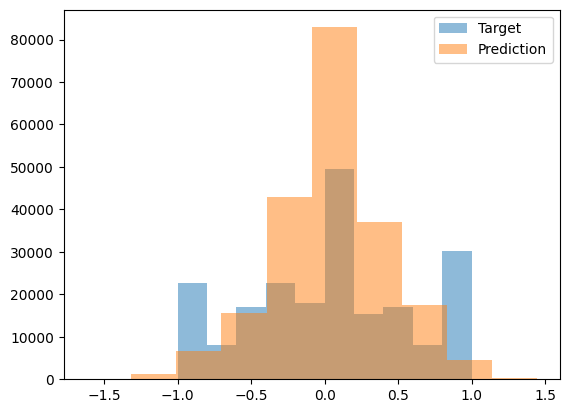

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***